# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt
from matplotlib import rcParams

import sys
import time

sys.path.append("../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [10]:
epochs = 75
num_lstm_neurons = 256
num_pre_out_neurons = 256
onehot_dims = 4

# Load & Prepare the data

In [4]:
enc_dict = {"(": [1.0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0],
            "x": [.0, .0, 1.0, .0],
            "@x.": [.0, .0, .0, 1.0]}
tokens_pattern = r"(\(|\)|@x\.|x)"


def tokenize_data(simplified_term):
    return re.findall(tokens_pattern, simplified_term)


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(enc_dict[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_

In [5]:
all_data = pd.read_csv("./data/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

# make test/train split
x_train, x_test, y_train_, y_test_ = train_test_split(all_data["simple_terms"].tolist(),
                                                      all_data["steps_num_lo"].tolist(),
                                                      test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train_)}")
print(f"Count testing samples: {len(y_test_)}")

Count all terms: 4251

Count original terms: 4251

max steps count: 30
min steps count: 0
Count training samples: 2952
Count testing samples: 739


In [6]:
# one-hot encode y-data
encoder = LabelBinarizer()
encoder.fit(range(0, 31))
y_train = encoder.transform(y_train_)
y_test = encoder.transform(y_test_)

y_train_scaled = np.array(y_train_) / 30.0
y_test_scaled = np.array(y_test_) / 30.0

x_train = tokenize_and_vectorize(x_train)
x_test = tokenize_and_vectorize(x_test)

In [7]:
xy_train_data = list(zip(x_train, list(zip(y_train, y_train_scaled))))
xy_test_data = list(zip(x_test, list(zip(y_test, y_test_scaled))))

In [8]:
print(f"len(test_data) = {len(xy_test_data)}")
print(f"len(train_data) = {len(xy_train_data)}")

len(test_data) = 739
len(train_data) = 2952


In [9]:
def train_generator():
    while True:
        random.shuffle(xy_train_data)
        for xtd, ytd in xy_train_data:
            yield np.array([xtd]), (np.array([ytd[0]]), np.array([ytd[1]]))


def val_generator():
    while True:
        for xtd, ytd in xy_test_data:
            yield np.array([xtd]), (np.array([ytd[0]]), np.array([ytd[1]]))

# Define the model

In [11]:
from keras.layers import Input
from keras.models import Model

input_layer = Input(shape=(None, onehot_dims))
lstm_layer = LSTM(units=num_lstm_neurons)(input_layer)

pre_out_layer = Dense(units=num_pre_out_neurons, activation="relu")(lstm_layer)

output_cl_layer = Dense(units=31, activation="softmax", name="cl_out")(pre_out_layer)
output_reg_layer = Dense(units=1, name="reg_out")(pre_out_layer)

model = Model(inputs=input_layer, outputs=[output_cl_layer, output_reg_layer])

In [12]:
model.compile(loss={'cl_out': 'categorical_crossentropy',
                    'reg_out': 'mean_squared_error'},
              loss_weights={'cl_out': 0.9,
                            'reg_out': 0.1},
              optimizer='adam',
              metrics={'cl_out': ['accuracy'], 'reg_out': ['mean_absolute_error']})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 4)]            0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 256)                  267264    ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 256)                  65792     ['lstm[0][0]']                
                                                                                                  
 cl_out (Dense)              (None, 31)                   7967      ['dense[0][0]']               
                                                                                              

In [13]:
model_structure = model.to_json()
with open("./fine_models/v6.1_lstm_steps_pred_31_bins.json", 'w') as json_file:
    json_file.write(model_structure)

In [14]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='./fine_models/v6.1_lstm_steps_pred_31_bins.h5',  # Specify the path to save the best model
    monitor='cl_out_accuracy',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

In [15]:
history = model.fit(train_generator(), steps_per_epoch=2952, validation_data=val_generator(), validation_steps=739, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/75
2952/2952 [==============================] - 227s 76ms/step - loss: 2.7048 - cl_out_loss: 2.9998 - reg_out_loss: 0.0499 - cl_out_accuracy: 0.1023 - reg_out_mean_absolute_error: 0.1682 - val_loss: 2.7018 - val_cl_out_loss: 2.9966 - val_reg_out_loss: 0.0488 - val_cl_out_accuracy: 0.1001 - val_reg_out_mean_absolute_error: 0.1789
Epoch 2/75
   1/2952 [..............................] - ETA: 3:04 - loss: 3.2292 - cl_out_loss: 3.5860 - reg_out_loss: 0.0179 - cl_out_accuracy: 0.0000e+00 - reg_out_mean_absolute_error: 0.1337

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2952/2952 [==============================] - 245s 83ms/step - loss: 2.6783 - cl_out_loss: 2.9707 - reg_out_loss: 0.0473 - cl_out_accuracy: 0.1104 - reg_out_mean_absolute_error: 0.1669 - val_loss: 2.6936 - val_cl_out_loss: 2.9874 - val_reg_out_loss: 0.0493 - val_cl_out_accuracy: 0.1001 - val_reg_out_mean_absolute_error: 0.1812
Epoch 3/75
2952/2952 [==============================] - 224s 76ms/step - loss: 2.6746 - cl_out_loss: 2.9666 - reg_out_loss: 0.0472 - cl_out_accuracy: 0.1020 - reg_out_mean_absolute_error: 0.1666 - val_loss: 2.6903 - val_cl_out_loss: 2.9840 - val_reg_out_loss: 0.0475 - val_cl_out_accuracy: 0.1001 - val_reg_out_mean_absolute_error: 0.1694
Epoch 4/75
2952/2952 [==============================] - 206s 70ms/step - loss: 2.6714 - cl_out_loss: 2.9630 - reg_out_loss: 0.0470 - cl_out_accuracy: 0.1043 - reg_out_mean_absolute_error: 0.1662 - val_loss: 2.6909 - val_cl_out_loss: 2.9846 - val_reg_out_loss: 0.0478 - val_cl_out_accuracy: 0.1083 - val_reg_out_mean_absolute_error: 0

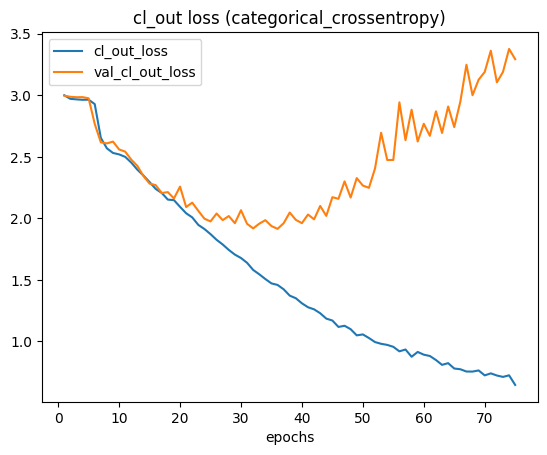

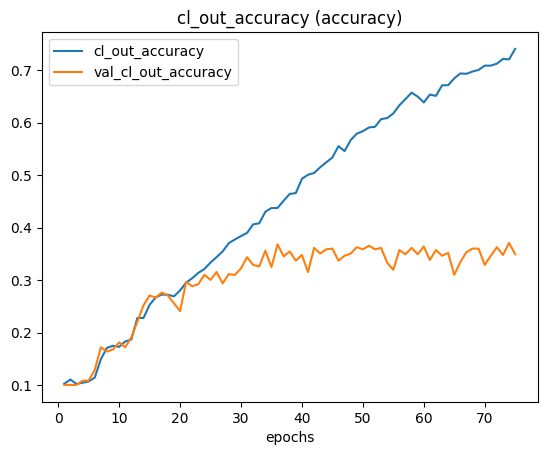

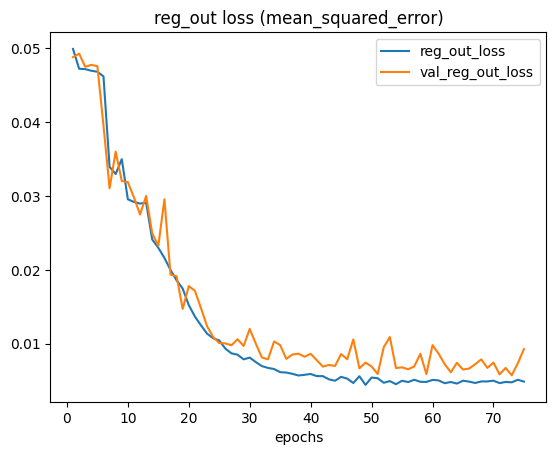

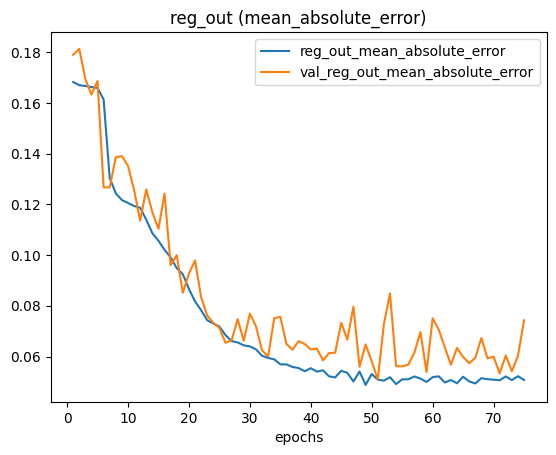

In [16]:
plt.plot(range(1, epochs + 1), history.history['cl_out_loss'], label="cl_out_loss")
plt.plot(range(1, epochs + 1), history.history['val_cl_out_loss'], label="val_cl_out_loss")
plt.xlabel("epochs")
plt.title("cl_out loss (categorical_crossentropy)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['cl_out_accuracy'], label="cl_out_accuracy")
plt.plot(range(1, epochs + 1), history.history['val_cl_out_accuracy'], label="val_cl_out_accuracy")
plt.xlabel("epochs")
plt.title("cl_out_accuracy (accuracy)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['reg_out_loss'], label="reg_out_loss")
plt.plot(range(1, epochs + 1), history.history['val_reg_out_loss'], label="val_reg_out_loss")
plt.xlabel("epochs")
plt.title("reg_out loss (mean_squared_error)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['reg_out_mean_absolute_error'], label="reg_out_mean_absolute_error")
plt.plot(range(1, epochs + 1), history.history['val_reg_out_mean_absolute_error'], label="val_reg_out_mean_absolute_error")
plt.xlabel("epochs")
plt.title("reg_out (mean_absolute_error)")

plt.legend()
plt.show()

In [17]:
# load the model
with open("./fine_models/v6.1_lstm_steps_pred_31_bins.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("./fine_models/v6.1_lstm_steps_pred_31_bins.h5")

In [19]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

In [18]:
y_train_pred = []
y_train_pred_reg = []
for x_ in tqdm(x_train):
    prediction = model.predict(np.array([x_]), verbose=0)
    y_train_pred.append(prediction[0])
    y_train_pred_reg.append(prediction[1])

100%|██████████| 2952/2952 [03:09<00:00, 15.59it/s]


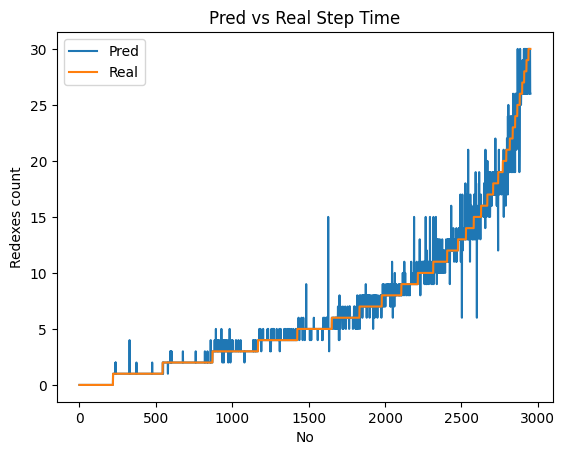

In [20]:
y_train_pred_nums = [np.argmax(y_) for y_ in y_train_pred]
y_train_nums = encoder.inverse_transform(y_train)

draw_pred_lines(y_train_pred_nums, y_train_nums)

In [21]:
print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))

Train accuracy: 0.8092818428184282


In [22]:
y_test_pred = []
y_test_pred_reg = []
for x_ in tqdm(x_test):
    prediction = model.predict(np.array([x_]), verbose=0)
    y_test_pred.append(prediction[0])
    y_test_pred_reg.append(prediction[1])

100%|██████████| 739/739 [00:43<00:00, 17.05it/s]


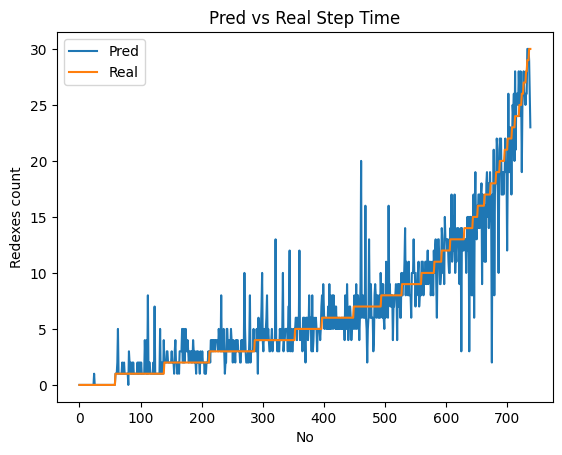

In [23]:
y_test_pred_nums = [np.argmax(y_) for y_ in y_test_pred]
y_test_nums = encoder.inverse_transform(y_test)

draw_pred_lines(y_test_pred_nums, y_test_nums)

In [24]:
print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))

Test accuracy: 0.3491204330175913


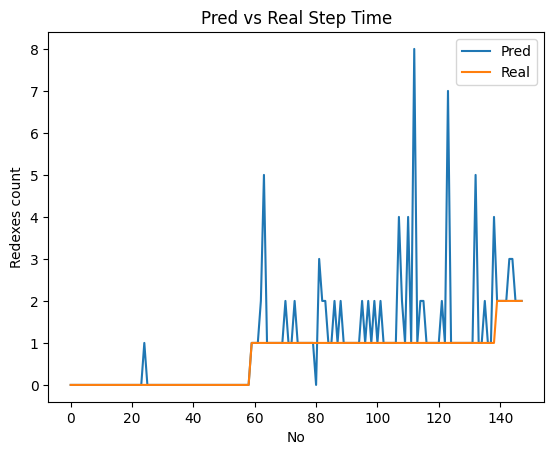

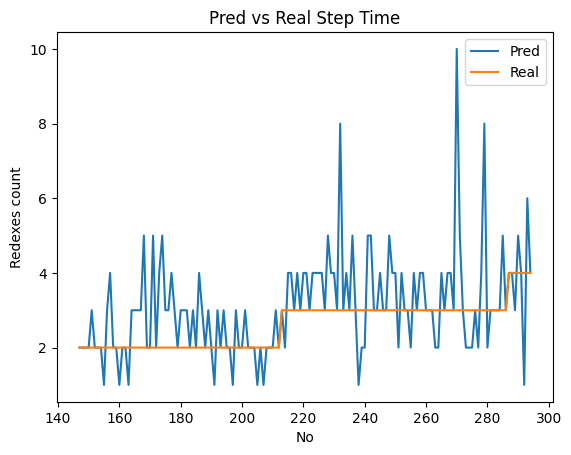

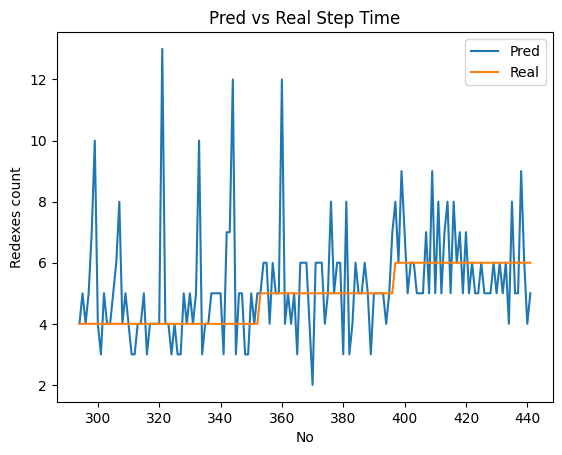

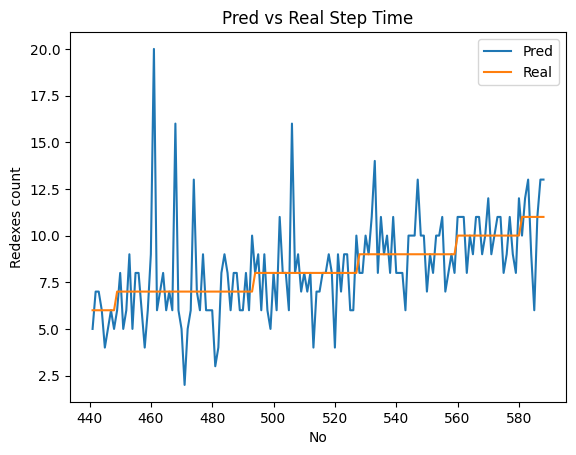

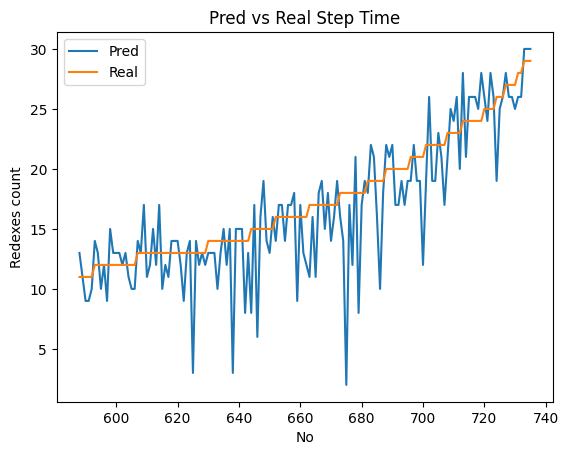

In [25]:
def draw_pred_lines_steps(y_pred, y_real, ranges):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    range_step = int(len(y_pred) / ranges)
    for range_no in range(ranges):
        for key_, val_ in drawing_df.items():
            plt.plot(range(range_no * range_step, ((range_no + 1) * range_step) + 1),
                     val_[range_no * range_step: ((range_no + 1) * range_step) + 1], label=key_)

        plt.xlabel("No")
        plt.ylabel("Redexes count")
        plt.title("Pred vs Real Step Time")
        plt.legend()
        plt.show()


draw_pred_lines_steps(y_test_pred_nums, y_test_nums, 5)

In [26]:
def ite_term():
    x, y, c = Var(), Var(), Var()
    x_, y_, c_ = Atom(x), Atom(y), Atom(c)
    return Lambda(c, Lambda(x, Lambda(y, multi_app_term(c_, x_, y_))))


def true_term():
    x, y = Var(), Var()
    x_ = Atom(x)
    return Lambda(x, Lambda(y, x_))


def num_zero_term():
    s, z = Var(), Var()
    z_ = Atom(z)
    return Lambda(s, Lambda(z, z_))


def num_term(n: int):
    if n <= 0:
        return num_zero_term()
    s, z = Var(), Var()
    s_, z_ = Atom(s), Atom(z)
    core_term = App(s_, z_)
    for _ in range(n - 1):
        core_term = App(s_, core_term)
    return Lambda(s, Lambda(z, core_term))


def multi_app_term(term_0: Term, term_1: Term, *terms: Term):
    res_app_term = App(term_0, term_1)
    for term in terms:
        res_app_term = App(res_app_term, term)
    return res_app_term


def false_term():
    x, y = Var(), Var()
    y_ = Atom(y)
    return Lambda(x, Lambda(y, y_))


def pair_term():
    x, y, p = Var(), Var(), Var()
    x_, y_, p_ = Atom(x), Atom(y), Atom(p)
    return Lambda(x, Lambda(y, Lambda(p, multi_app_term(p_, x_, y_))))


def first_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, true_term()))


def second_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, false_term()))


def succ_term():
    x, y, n = Var(), Var(), Var()
    x_, y_, n_ = Atom(x), Atom(y), Atom(n)
    return Lambda(n, Lambda(x, Lambda(y, App(x_, multi_app_term(n_, x_, y_)))))


def sinc_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(
        p,
        multi_app_term(
            pair_term(),
            App(second_term(), p_),
            App(succ_term(), App(second_term(), p_)),
        ),
    )


def pred_term():
    n, f, x, g, h, u = Var(), Var(), Var(), Var(), Var(), Var()
    n_, f_, x_ = Atom(n), Atom(f), Atom(x)
    g_, h_, u_ = Atom(g), Atom(h), Atom(u)

    return Lambda(n, Lambda(f, Lambda(x, multi_app_term(
        n_,
        Lambda(g, Lambda(h, App(h_, App(g_, f_)))),
        Lambda(u, x_),
        Lambda(u, u_)
    ))))


def plus_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(m, Lambda(n, multi_app_term(n_, succ_term(), m_)))


def subtract_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(n, Lambda(m, multi_app_term(m_, pred_term(), n_)))


def iszero_term():
    x, n = Var(), Var()
    n_ = Atom(n)
    return Lambda(n, App(App(n_, Lambda(x, false_term())), true_term()))


def leq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n, Lambda(m, App(iszero_term(), multi_app_term(subtract_term(), n_, m_)))
    )


def and_term():
    a, b = Var(), Var()
    a_, b_ = Atom(a), Atom(b)
    return Lambda(a, Lambda(b, multi_app_term(ite_term(), a_, b_, a_)))


def eq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n,
        Lambda(
            m,
            multi_app_term(
                and_term(),
                multi_app_term(leq_term(), n_, m_),
                multi_app_term(leq_term(), m_, n_),
            ),
        ),
    )


def i_term():
    x = Var()
    x_ = Atom(x)
    return Lambda(x, x_)


def omega_term(n: int):
    x = Var()
    x_ = Atom(x)
    body_app_term = x_
    for _ in range(n - 1):
        body_app_term = App(body_app_term, x_)
    return Lambda(x, body_app_term)


def multi_i_term(m: int):
    app_term = i_term()
    for _ in range(m - 1):
        app_term = App(app_term, i_term())
    return app_term


def omega_multi_i_term(n: int, m: int):
    return App(omega_term(n), multi_i_term(m))


def term_test_1():
    x, y = Var(), Var()
    x_, y_ = Atom(x), Atom(y)

    return "(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x", \
        App(
            Lambda(x, Lambda(y, y_)),
            App(
                Lambda(x, App(x_, x_)),
                Lambda(x, App(x_, x_))
            )
        )


def term_test_2():
    return "(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(ite_term(), true_term(), num_term(3), num_term(1))


def term_test_3():
    return "(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(ite_term(), false_term(), num_term(0), num_term(4))


def term_test_4():
    return "(PRED 0) == 0 == λx. λy. y", \
        multi_app_term(pred_term(), num_term(0))


def term_test_5():
    return "(PRED 5) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(pred_term(), num_term(5))


def term_test_6():
    return "(PLUS 0 0) == 0 == λx. λy. y", \
        multi_app_term(plus_term(), num_term(0), num_term(0))


def term_test_7():
    return "(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))", \
        multi_app_term(plus_term(), num_term(2), num_term(3))


def term_test_8():
    return "(SUBTRACT 4 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(subtract_term(), num_term(4), num_term(1))


def term_test_9():
    return "(SUBTRACT 3 5) == 0 == λx. λy. y", \
        multi_app_term(subtract_term(), num_term(3), num_term(5))


def term_test_10():
    return "(LEQ 3 2) == FALSE == λx. λy. y", \
        multi_app_term(leq_term(), num_term(3), num_term(2))


def term_test_11():
    return "(LEQ 2 5) == TRUE == λx. λy. x", \
        multi_app_term(leq_term(), num_term(2), num_term(5))


def term_test_12():
    return "(EQ 2 2) == TRUE == λx. λy. x", \
        multi_app_term(eq_term(), num_term(2), num_term(2))


def term_test_13():
    return "(EQ 1 4) == FALSE == λx. λy. y", \
        multi_app_term(eq_term(), num_term(1), num_term(4))


def term_test_14():
    return "Omega(3, 3)  == I == λx. x", \
        omega_multi_i_term(3, 3)


def term_test_15():
    return "GCD_vO 5 2", \
        multi_app_term(gcd_term_v0(), num_term(5), num_term(2))


def term_test_16():
    return "GCD_v1 5 2", \
        multi_app_term(gcd_term_v1(), num_term(5), num_term(2))


def term_test_17():
    return "GCD_v3 5 2", \
        multi_app_term(gcd_term_v3(), num_term(5), num_term(2))


def term_test_18():
    return "PYTHAGOREAN 5 2 2", \
        multi_app_term(
            pythagorean_term(), num_term(5), num_term(2), num_term(2)
        )


def test_function(term_deskr_: str, term_: Term, model_: Sequential):
    prediction_ = model_.predict(tokenize_and_vectorize([term_.simple_str()]), verbose=0)
    count_norm_steps = term_.normalize(LOStrategy())[1]
    cl_pred = np.argmax(prediction_[0][0])
    reg_pred = prediction_[1][0][0] * 30.0
    print(f"{term_deskr_}\nnorm_steps={count_norm_steps}\tcl_pred_steps={cl_pred}\treg_pred_steps={reg_pred}\n")


list_test_functions = (
    term_test_1, term_test_2, term_test_3, term_test_4, term_test_5, term_test_6, term_test_7, term_test_9,
    term_test_10,
    term_test_11, term_test_12, term_test_13, term_test_14, term_test_15, term_test_16, term_test_17, term_test_18)

for term_function in list_test_functions:
    term_deskr, term = term_function()
    test_function(term_deskr, term, model)

(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x
norm_steps=1	cl_pred_steps=3	reg_pred_steps=-0.8514788746833801

(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))
norm_steps=5	cl_pred_steps=6	reg_pred_steps=4.765846431255341

(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=5	cl_pred_steps=5	reg_pred_steps=4.286365360021591

(PRED 0) == 0 == λx. λy. y
norm_steps=4	cl_pred_steps=3	reg_pred_steps=-3.207813799381256

(PRED 5) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=15	cl_pred_steps=2	reg_pred_steps=-0.15547066926956177

(PLUS 0 0) == 0 == λx. λy. y
norm_steps=4	cl_pred_steps=4	reg_pred_steps=1.2509071826934814

(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))
norm_steps=13	cl_pred_steps=3	reg_pred_steps=3.7271641194820404

(SUBTRACT 3 5) == 0 == λx. λy. y
norm_steps=39	cl_pred_steps=5	reg_pred_steps=5.880971252918243

(LEQ 3 2) == FALSE == λx. λy. y
norm_steps=28	cl_pred_steps=5	reg_pred_steps=7.698456645011902

(LEQ 2 5) == TRUE == λx. λy. x
norm_steps=37	cl_pred_steps=3	r

In [27]:
list_simplified_omega_terms = []

for n in range(1, 21):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        list_simplified_omega_terms.append(term_.simple_str())

list_simplified_omega_terms = tokenize_and_vectorize(list_simplified_omega_terms)

real_redexes_count = []

for n in tqdm(range(1, 21)):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        real_redexes_count.append(term_.normalize(LOStrategy())[1])

cl_pred_omega_terms_redexes = []
reg_pred_omega_terms_redexes = []
for rec_ in tqdm(list_simplified_omega_terms):
    prediction_ = model.predict([rec_], verbose=0)
    cl_pred = np.argmax(prediction_[0][0])
    reg_pred = prediction_[1][0][0] * 30.0

    cl_pred_omega_terms_redexes.append(cl_pred)
    reg_pred_omega_terms_redexes.append(reg_pred)

100%|██████████| 400/400 [00:32<00:00, 12.43it/s]


In [28]:
print(cl_pred_omega_terms_redexes)

[1, 2, 4, 4, 5, 6, 7, 8, 9, 9, 8, 8, 8, 7, 7, 7, 7, 7, 8, 9, 2, 4, 6, 6, 6, 7, 8, 8, 8, 7, 7, 6, 6, 7, 7, 7, 7, 8, 8, 8, 2, 4, 6, 5, 6, 7, 8, 8, 8, 8, 8, 7, 7, 6, 6, 7, 7, 7, 8, 8, 3, 5, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 9, 10, 11, 11, 11, 11, 13, 13, 4, 5, 8, 8, 8, 9, 9, 9, 8, 8, 8, 8, 9, 9, 11, 11, 11, 13, 13, 13, 5, 6, 9, 9, 9, 9, 9, 9, 8, 8, 8, 9, 9, 10, 11, 11, 11, 13, 13, 13, 5, 6, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 9, 9, 9, 9, 8, 8, 8, 5, 6, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 8, 5, 6, 9, 9, 9, 9, 9, 9, 9, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 6, 9, 10, 9, 9, 10, 10, 9, 9, 8, 8, 7, 7, 7, 7, 7, 7, 7, 8, 6, 6, 9, 9, 9, 10, 10, 10, 10, 9, 9, 9, 8, 8, 7, 7, 7, 7, 7, 8, 6, 6, 8, 9, 9, 9, 10, 10, 10, 10, 9, 9, 8, 8, 8, 8, 7, 7, 8, 8, 9, 6, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 7, 7, 7, 8, 9, 6, 6, 7, 7, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 3, 4, 5, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 7, 7, 1, 2, 2, 3, 4, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 7, 7, 7, 1, 2, 2,

In [29]:
print(reg_pred_omega_terms_redexes)

[-2.5655382871627808, -1.2207913398742676, 4.89583745598793, 5.1976436376571655, 5.8151498436927795, 7.226189374923706, 8.209447860717773, 10.443290770053864, 11.239895224571228, 10.12600690126419, 9.125072658061981, 8.757295310497284, 8.69890809059143, 8.183126449584961, 8.191596865653992, 8.225581347942352, 8.292292356491089, 8.458939790725708, 9.013862907886505, 9.816560447216034, -3.885761797428131, 5.029960870742798, 6.340257525444031, 6.471666991710663, 7.360819727182388, 8.128602504730225, 9.2634978890419, 8.996233642101288, 8.6333629488945, 8.400208353996277, 8.309494256973267, 7.926866412162781, 7.952838242053986, 8.141173124313354, 8.175866603851318, 8.272867798805237, 8.343072831630707, 8.636906147003174, 9.046856760978699, 9.447312355041504, -3.823389708995819, 4.141394644975662, 6.98833554983139, 6.886176913976669, 7.999991476535797, 8.181670904159546, 9.126450419425964, 9.590841829776764, 9.529646337032318, 9.276872277259827, 9.170268774032593, 8.330247402191162, 8.334741

In [30]:
print(real_redexes_count)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133, 140, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 11, 22, 33, 44, 55, 66, 77, 88, 99, 110, 121, 132, 143, 154, 165, 176, 187, 198, 209, 220, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, 240, 

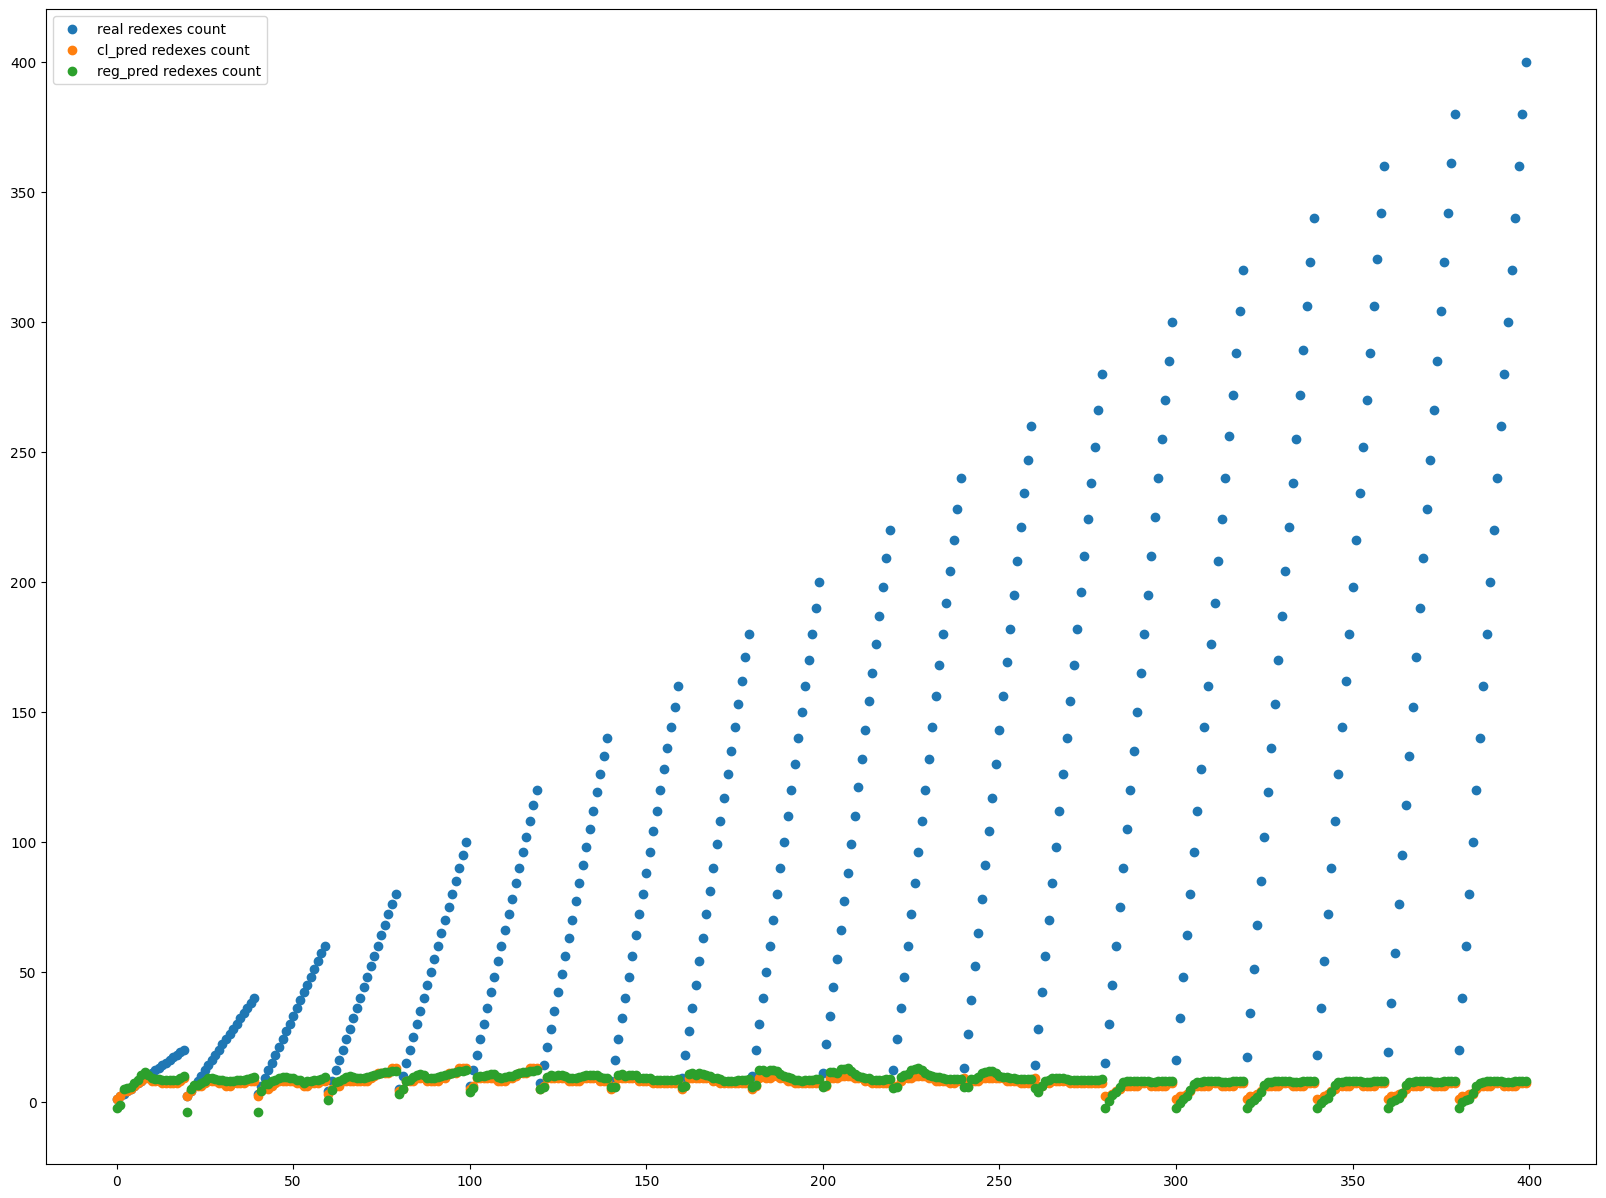

In [31]:
rcParams['figure.figsize'] = 20, 15

plt.scatter(range(0, len(real_redexes_count)), real_redexes_count, label="real redexes count")
plt.scatter(range(0, len(real_redexes_count)), cl_pred_omega_terms_redexes, label="cl_pred redexes count")
plt.scatter(range(0, len(real_redexes_count)), reg_pred_omega_terms_redexes, label="reg_pred redexes count")

plt.legend()
plt.show()

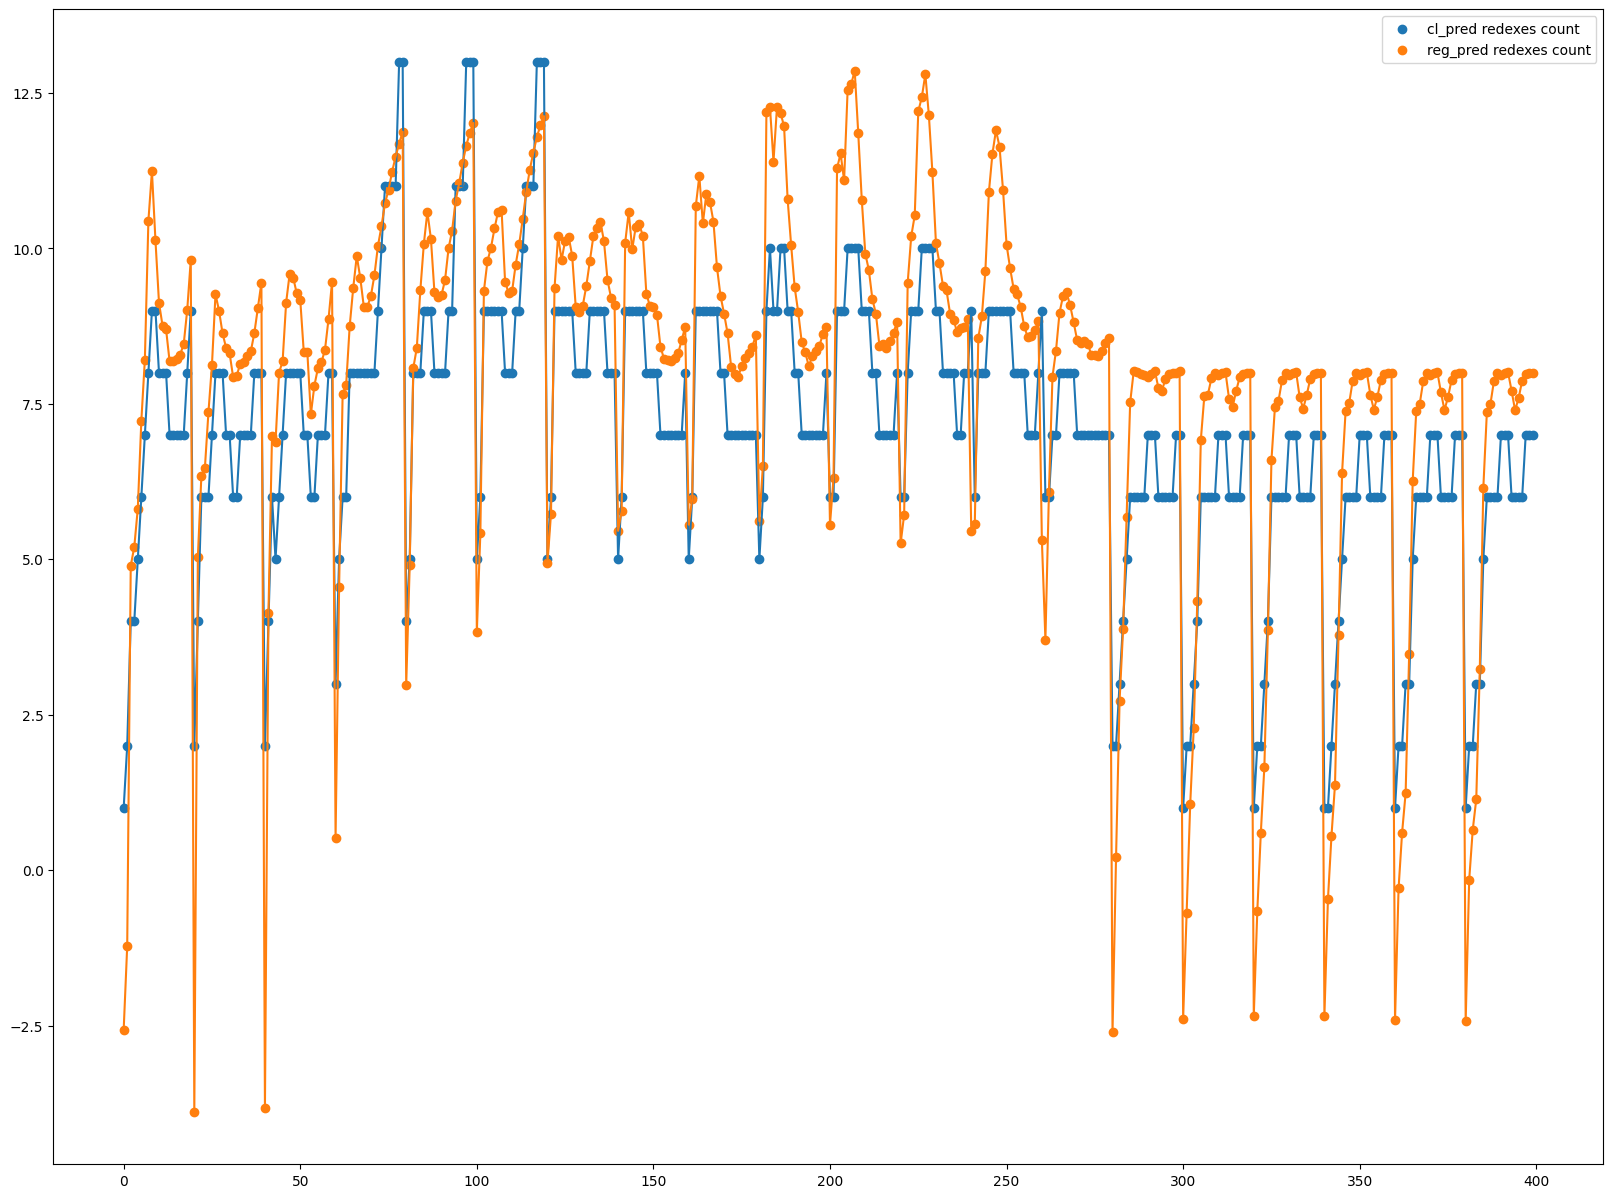

In [32]:
rcParams['figure.figsize'] = 20, 15

plt.scatter(range(0, len(real_redexes_count)), cl_pred_omega_terms_redexes, label="cl_pred redexes count")
plt.plot(range(0, len(real_redexes_count)), cl_pred_omega_terms_redexes)
plt.scatter(range(0, len(real_redexes_count)), reg_pred_omega_terms_redexes, label="reg_pred redexes count")
plt.plot(range(0, len(real_redexes_count)), reg_pred_omega_terms_redexes)

plt.legend()
plt.show()

In [33]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(real_redexes_count, cl_pred_omega_terms_redexes))

Test accuracy: 0.0275


In [34]:
green_dots = []
red_dots = []

for n in range(0, 20):
    for m in range(0, 20):
        val = cl_pred_omega_terms_redexes[n * 20 + m]
        val_real = real_redexes_count[n * 20 + m]

        if val == val_real:
            green_dots.append((n + 1, m + 1))
        else:
            red_dots.append((n + 1, m + 1))


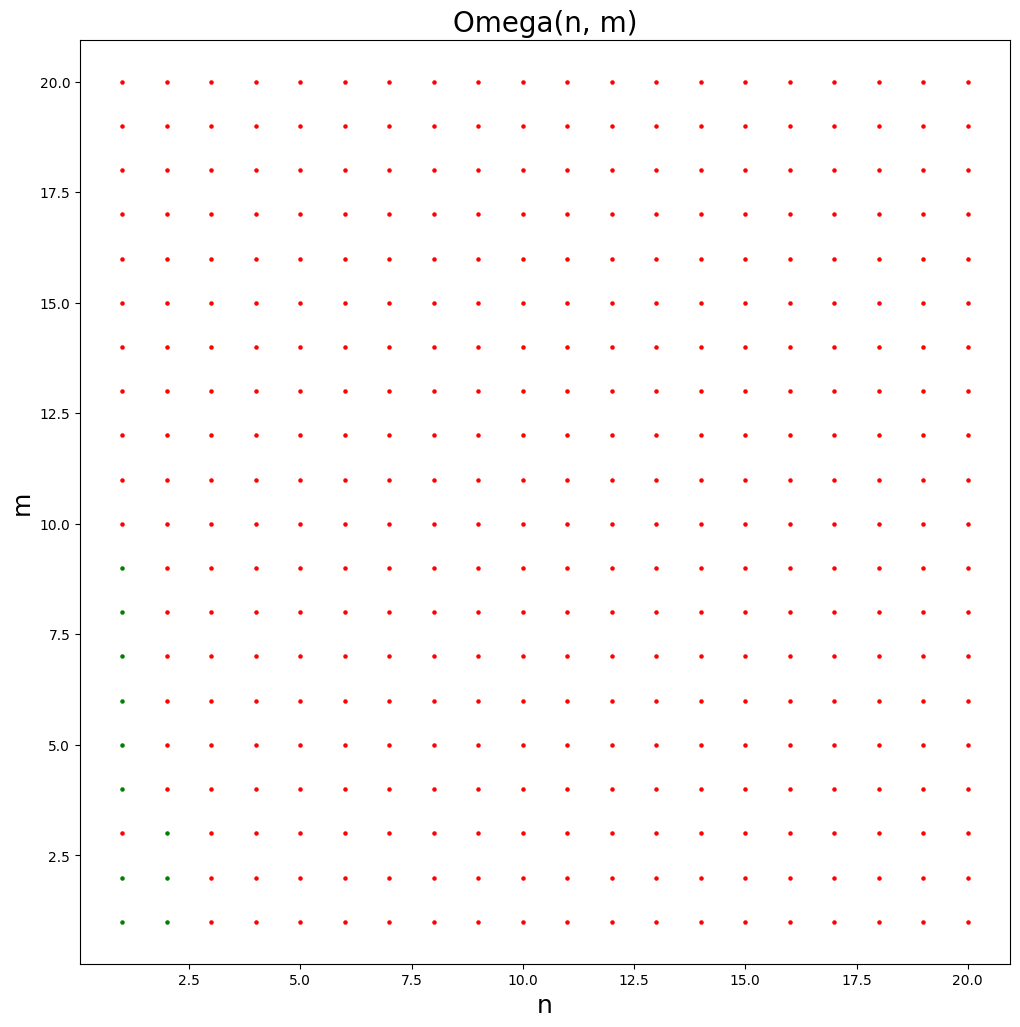

In [35]:
plt.figure(figsize=(12, 12))

green_dots = np.array(green_dots)
red_dots = np.array(red_dots)

plt.scatter(green_dots[:, 0], green_dots[:, 1], s=5, c='green', )
plt.scatter(red_dots[:, 0], red_dots[:, 1], s=5, c='red', )

plt.xlabel("n", fontsize=18)
plt.ylabel("m", fontsize=18)
plt.title("Omega(n, m)", fontsize=20)
plt.show()

# Do additional metrics testing

In [36]:
y_train_cl_pred_nums = [np.argmax(y_) for y_ in y_train_pred]
y_train_reg_pred_nums = np.array([y_[0][0] for y_ in y_train_pred_reg]) * 30.0

y_train_nums = encoder.inverse_transform(y_train)

In [37]:
y_test_cl_pred_nums = [np.argmax(y_) for y_ in y_test_pred]
y_test_reg_pred_nums = np.array([y_[0][0] for y_ in y_test_pred_reg]) * 30.0

y_test_nums = encoder.inverse_transform(y_test)

## Mean Squared Error

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

In [39]:
mse_train = mean_squared_error(y_train_nums, y_train_cl_pred_nums)
mse_train_reg = mean_squared_error(y_train_nums, y_train_reg_pred_nums)
print("Train {Mean Squared Error}:", mse_train)
print("Train reg {Mean Squared Error}:", mse_train_reg)

mse_test = mean_squared_error(y_test_nums, y_test_cl_pred_nums)
mse_test_reg = mean_squared_error(y_test_nums, y_test_reg_pred_nums)
print("Test {Mean Squared Error}:", mse_test)
print("Test reg {Mean Squared Error}:", mse_test_reg)

Train {Mean Squared Error}: 0.6233062330623306
Train reg {Mean Squared Error}: 5.757845073197193
Test {Mean Squared Error}: 4.561569688768606
Test reg {Mean Squared Error}: 8.348451483508697


## Mean Absolute Error

In [40]:
mae_train = mean_absolute_error(y_train_nums, y_train_cl_pred_nums)
mae_train_reg = mean_absolute_error(y_train_nums, y_train_reg_pred_nums)
print("Train {Mean Absolute Error}:", mae_train)
print("Train reg {Mean Absolute Error}:", mae_train_reg)

mae_test = mean_absolute_error(y_test_nums, y_test_cl_pred_nums)
mae_test_reg = mean_absolute_error(y_test_nums, y_test_reg_pred_nums)
print("Test {Mean Absolute Error}:", mae_test)
print("Test reg{Mean Absolute Error}:", mae_test_reg)

Train {Mean Absolute Error}: 0.279810298102981
Train reg {Mean Absolute Error}: 1.903435195647281
Test {Mean Absolute Error}: 1.246278755074425
Test reg{Mean Absolute Error}: 2.228020124812894


## Mean Absolute Percentage Error

In [41]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    percentage_errors = np.abs((y_true - y_pred) / y_true_fix) * 100
    mape = np.mean(percentage_errors)
    return mape


mape_train = mean_absolute_percentage_error(y_train_nums, y_train_cl_pred_nums)
mape_train_reg = mean_absolute_percentage_error(y_train_nums, y_train_reg_pred_nums)
print("Train {Mean Absolute Percentage Error}:", mape_train)
print("Train reg {Mean Absolute Percentage Error}:", mape_train_reg)

mape_test = mean_absolute_percentage_error(y_test_nums, y_test_cl_pred_nums)
mape_test_reg = mean_absolute_percentage_error(y_test_nums, y_test_reg_pred_nums)
print("Test {Mean Absolute Percentage Error}:", mape_test)
print("Test reg {Mean Absolute Percentage Error}:", mape_test_reg)

Train {Mean Absolute Percentage Error}: 3.1337448379484414
Train reg {Mean Absolute Percentage Error}: 164111.920078963
Test {Mean Absolute Percentage Error}: 1377.6743457656373
Test reg {Mean Absolute Percentage Error}: 151261.97873411956


## Percentage of Explained Variance (PEV)

In [42]:
# Calculate Variance of the target variable
variance_y_test = np.var(y_test_nums)
variance_y_train = np.var(y_train_nums)

# Calculate Percentage of Explained Variance (PEV)
pev_test = (1 - mse_test / variance_y_test) * 100
pev_test_reg = (1 - mse_test_reg / variance_y_test) * 100
pev_train = (1 - mse_train / variance_y_train) * 100
pev_train_reg = (1 - mse_train_reg / variance_y_train) * 100

print("Train {Percentage of Explained Variance}:", pev_train)
print("Train reg {Percentage of Explained Variance}:", pev_train_reg)
print("Test {Percentage of Explained Variance}:", pev_test)
print("Test reg {Percentage of Explained Variance}:", pev_test_reg)

Train {Percentage of Explained Variance}: 98.50376784718341
Train reg {Percentage of Explained Variance}: 86.1784264740495
Test {Percentage of Explained Variance}: 89.29516793199424
Test reg {Percentage of Explained Variance}: 80.40832931284689


## Mean Bias Deviation

In [43]:
def mean_bias_deviation(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    n = len(y_true)
    mbd = np.sum((y_pred - y_true) / y_true_fix) * 100 / n
    return mbd


mbd_train = mean_bias_deviation(y_train_nums, y_train_cl_pred_nums)
mbd_train_reg = mean_bias_deviation(y_train_nums, y_train_reg_pred_nums)
print("Train {Mean Bias Deviation}:", mbd_train)
print("Train reg {Mean Bias Deviation}:", mbd_train_reg)

mdb_test = mean_bias_deviation(y_test_nums, y_test_cl_pred_nums)
mdb_test_reg = mean_bias_deviation(y_test_nums, y_test_reg_pred_nums)
print("Test {Mean Bias Deviation}:", mdb_test)
print("Test reg {Mean Bias Deviation}:", mdb_test_reg)

Train {Mean Bias Deviation}: 1.1721479711496532
Train reg {Mean Bias Deviation}: -160186.98389422652
Test {Mean Bias Deviation}: 1364.2715812101367
Test reg {Mean Bias Deviation}: -151026.64514797344


## Coefficient of Correlation (Pearson's r)

In [44]:
coc_test = np.corrcoef(y_test_cl_pred_nums, y_test_nums)[0, 1]
coc_test_reg = np.corrcoef(y_test_reg_pred_nums, y_test_nums)[0, 1]
coc_train = np.corrcoef(y_train_cl_pred_nums, y_train_nums)[0, 1]
coc_train_reg = np.corrcoef(y_train_reg_pred_nums, y_train_nums)[0, 1]

print("Train {Mean Bias Deviation}:", coc_train)
print("Train reg {Mean Bias Deviation}:", coc_train_reg)
print("Test {Mean Bias Deviation}:", coc_test)
print("Test reg {Mean Bias Deviation}:", coc_test_reg)

Train {Mean Bias Deviation}: 0.9925385242222758
Train reg {Mean Bias Deviation}: 0.9517140096766266
Test {Mean Bias Deviation}: 0.9454401510958345
Test reg {Mean Bias Deviation}: 0.9163654351014509
